## **Models**

#### **Load Cleaned Dataset**

In [6]:
import pandas as pd, numpy as np, re, matplotlib.pyplot as plt
from pathlib import Path

DATA_PATH = "pipe_leak_training_dataset_fresh.pkl"  # adjust if needed
TARGET = "target_leak"

df = pd.read_pickle(DATA_PATH)

# Convert event_date to datetime if needed
if "event_date" in df.columns:
    df["event_date"] = pd.to_datetime(df["event_date"], errors="coerce")

# keep rows with a valid label
assert TARGET in df.columns, f"Missing {TARGET} column."
print(df.shape, df[TARGET].value_counts(normalize=True).round(3))

(6260, 21) target_leak
0    0.819
1    0.181
Name: proportion, dtype: float64


#### **Join key for history**

In [8]:
if "Functional Loc." in df.columns:
    KEY = "Functional Loc."
elif "final__PIPELINE NAME" in df.columns:
    KEY = "final__PIPELINE NAME"
else:
    KEY = "final__SUB SYSTEM"
print("Using KEY:", KEY)


Using KEY: Functional Loc.


#### **Base features**

In [9]:
# ensure year/month exist
df["event_year"] = pd.to_datetime(df["event_date"]).dt.year
df["event_month"] = pd.to_datetime(df["event_date"]).dt.month

# cyclic month
df["m_sin"] = np.sin(2*np.pi*(df["event_month"]%12)/12)
df["m_cos"] = np.cos(2*np.pi*(df["event_month"]%12)/12)

# clean categoricals (consistent Unknown token)
for c in ["final__Material","final__SYSTEM","final__SUB SYSTEM"]:
    if c in df.columns:
        df[c] = (df[c].replace({None: np.nan, "None": np.nan, "": np.nan, "nan": np.nan})
                       .fillna("Unknown"))


#### **History features**

In [10]:
# sort deterministically
df = df.sort_values(["event_date", KEY]).reset_index(drop=True)

# previous event date & days since
df["prev_event_date_any"] = df.groupby(KEY)["event_date"].shift(1)
df["days_since_last_event"] = (df["event_date"] - df["prev_event_date_any"]).dt.days.fillna(9999)

# previous leak flag
df["prev_leak_flag"] = df.groupby(KEY)[TARGET].shift(1).fillna(0).astype(int)

# previous leak date & days since
leak_dates = df["event_date"].where(df[TARGET].eq(1))
df["prev_leak_date"] = leak_dates.groupby(df[KEY]).shift(1)
df["days_since_last_leak"] = (df["event_date"] - df["prev_leak_date"]).dt.days.fillna(9999)

# cumulative counts up to previous row
df["cum_events"] = df.groupby(KEY).cumcount()
df["cum_leaks"]  = df.groupby(KEY)[TARGET].transform(lambda s: s.shift(1).fillna(0).cumsum()).astype(int)


#### **Final feature lists**

In [11]:
NUM_COLS = [c for c in [
    "final__Nominal Diameter","final__PIPELINE AGE","final__TOTAL LENGTH (KM)",
    "final__CAPACITY MLD","event_year","event_month","m_sin","m_cos",
    "days_since_last_event","days_since_last_leak","cum_events","cum_leaks","prev_leak_flag"
] if c in df.columns]

CAT_COLS = [c for c in ["final__Material","final__SYSTEM","final__SUB SYSTEM"] if c in df.columns]

FEATURE_COLS = NUM_COLS + CAT_COLS
print("NUM:", NUM_COLS)
print("CAT:", CAT_COLS)


NUM: ['final__Nominal Diameter', 'final__PIPELINE AGE', 'final__TOTAL LENGTH (KM)', 'final__CAPACITY MLD', 'event_year', 'event_month', 'm_sin', 'm_cos', 'days_since_last_event', 'days_since_last_leak', 'cum_events', 'cum_leaks', 'prev_leak_flag']
CAT: ['final__Material', 'final__SYSTEM', 'final__SUB SYSTEM']


#### **Time-aware split (80% train / 20% test) + validation from train (last 20%)**

In [12]:
df = df.sort_values("event_date").reset_index(drop=True)
cutoff = df["event_date"].quantile(0.80)
train = df[df["event_date"] < cutoff].copy()
test  = df[df["event_date"] >= cutoff].copy()

# validation slice from TRAIN timeframe (last 20% of train)
tr_sorted = train.sort_values("event_date").reset_index(drop=True)
cut_val   = tr_sorted["event_date"].quantile(0.80)
train_core = tr_sorted[tr_sorted["event_date"] < cut_val].copy()
val_core   = tr_sorted[tr_sorted["event_date"] >= cut_val].copy()

print("train/test:", train.shape, test.shape, "| train_core/val_core:", train_core.shape, val_core.shape)


train/test: (4987, 30) (1273, 30) | train_core/val_core: (3978, 30) (1009, 30)


#### **Preprocessor**

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

def make_ohe_dense():
    try:    return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except: return OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_tf = Pipeline([("imp", SimpleImputer(strategy="median")),
                       ("sc", StandardScaler())])

categorical_tf = Pipeline([("imp", SimpleImputer(strategy="constant", fill_value="Unknown")),
                           ("ohe", make_ohe_dense())])

preprocess = ColumnTransformer(
    [("num", numeric_tf, NUM_COLS),
     ("cat", categorical_tf, CAT_COLS)],
    remainder="drop"
)


#### **Helper: fit/evaluate with thresholds**

In [14]:
from sklearn.metrics import (precision_recall_curve, classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score)

def pick_threshold_from_val(model, X_val, y_val, mode="f05", target_precision=0.40):
    proba = model.predict_proba(X_val)[:,1]
    prec, rec, thr = precision_recall_curve(y_val, proba)
    if mode == "precision":
        mask = prec[1:] >= target_precision
        return float(thr[mask][-1]) if mask.any() else 0.5
    # default F0.5 (precision-weighted)
    beta=0.5
    f = (1+beta**2)*prec*rec/(beta**2*prec + rec + 1e-12)
    return float(thr[np.nanargmax(f[1:])]) if len(thr) else 0.5

def evaluate_on_test(model, X_te, y_te, thr=0.5, name="model"):
    proba = model.predict_proba(X_te)[:,1]
    pred  = (proba >= thr).astype(int)
    print(f"\n=== {name} @thr={thr:.4f} ===")
    print("ROC-AUC:", round(roc_auc_score(y_te, proba),4), "| PR-AUC:", round(average_precision_score(y_te, proba),4))
    print(classification_report(y_te, pred, digits=3))
    print("Confusion:\n", confusion_matrix(y_te, pred))
    return proba, pred


#### **Logistic Regression**

In [15]:
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", solver="saga", n_jobs=-1))
])

pipe_lr.fit(train[FEATURE_COLS], train[TARGET].values)

# threshold from VAL (F0.5)
Xval = val_core[FEATURE_COLS]
yval = val_core[TARGET].values
thr_lr = pick_threshold_from_val(pipe_lr, Xval, yval, mode="f05")

# test eval
proba_lr, pred_lr = evaluate_on_test(pipe_lr, test[FEATURE_COLS], test[TARGET].values, thr=thr_lr, name="LogisticRegression")



=== LogisticRegression @thr=0.7307 ===
ROC-AUC: 0.6837 | PR-AUC: 0.3886
              precision    recall  f1-score   support

           0      0.813     0.963     0.882      1004
           1      0.560     0.175     0.266       269

    accuracy                          0.797      1273
   macro avg      0.686     0.569     0.574      1273
weighted avg      0.760     0.797     0.752      1273

Confusion:
 [[967  37]
 [222  47]]


#### **Random Forest**

In [16]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=600, max_depth=None, min_samples_leaf=2,
        class_weight="balanced", n_jobs=-1, random_state=42
    ))
])

pipe_rf.fit(train[FEATURE_COLS], train[TARGET].values)
thr_rf = pick_threshold_from_val(pipe_rf, Xval, yval, mode="f05")
proba_rf, pred_rf = evaluate_on_test(pipe_rf, test[FEATURE_COLS], test[TARGET].values, thr=thr_rf, name="RandomForest")



=== RandomForest @thr=0.5100 ===
ROC-AUC: 0.603 | PR-AUC: 0.2788
              precision    recall  f1-score   support

           0      0.800     0.943     0.866      1004
           1      0.360     0.119     0.179       269

    accuracy                          0.769      1273
   macro avg      0.580     0.531     0.522      1273
weighted avg      0.707     0.769     0.720      1273

Confusion:
 [[947  57]
 [237  32]]


#### **Deep Learning (Keras DNN on preprocessed features)**

In [17]:
# Build dense matrices once from the SAME preprocess (fit on TRAIN only)
Xtr = preprocess.fit_transform(train[FEATURE_COLS])
Xte = preprocess.transform(test[FEATURE_COLS])

ytr = train[TARGET].values
yte = test[TARGET].values

# class weights
from sklearn.utils.class_weight import compute_class_weight
classes = np.array([0,1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=ytr)
CLASS_WEIGHT = {0: float(cw[0]), 1: float(cw[1])}
CLASS_WEIGHT


{0: 0.6047780742178026, 1: 2.8859953703703702}

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks

def make_dnn(dim):
    inp = layers.Input(shape=(dim,))
    x = layers.Dense(256, activation="relu")(inp); x = layers.Dropout(0.35)(x)
    x = layers.Dense(128, activation="relu")(x);   x = layers.Dropout(0.25)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    m = tf.keras.Model(inp, out)
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=[tf.keras.metrics.AUC(name="AUC_ROC", curve="ROC"),
                       tf.keras.metrics.AUC(name="AUC_PR",  curve="PR")])
    return m

dnn = make_dnn(Xtr.shape[1])
es = callbacks.EarlyStopping(monitor="val_AUC_PR", mode="max", patience=10, restore_best_weights=True)
hist = dnn.fit(Xtr, ytr, validation_split=0.2, epochs=100, batch_size=256,
               class_weight=CLASS_WEIGHT, callbacks=[es], verbose=1)

proba_dnn = dnn.predict(Xte, verbose=0).ravel()


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC_PR: 0.2052 - AUC_ROC: 0.5119 - loss: 0.7073 - val_AUC_PR: 0.3635 - val_AUC_ROC: 0.6902 - val_loss: 0.6473
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC_PR: 0.3034 - AUC_ROC: 0.6415 - loss: 0.6640 - val_AUC_PR: 0.3712 - val_AUC_ROC: 0.7019 - val_loss: 0.6277
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC_PR: 0.2962 - AUC_ROC: 0.6476 - loss: 0.6535 - val_AUC_PR: 0.3650 - val_AUC_ROC: 0.6931 - val_loss: 0.6003
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC_PR: 0.3244 - AUC_ROC: 0.6657 - loss: 0.6544 - val_AUC_PR: 0.3739 - val_AUC_ROC: 0.7086 - val_loss: 0.5945
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC_PR: 0.3381 - AUC_ROC: 0.6666 - loss: 0.6439 - val_AUC_PR: 0.3729 - val_AUC_ROC: 0.7056 - val_loss: 0.5928
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC_PR: 0.3454 - AUC_ROC: 0.6813 - loss: 0.6368 - val_AUC_PR: 0.3672 - val_AUC_ROC: 0.7079 - val_loss: 0.5871
Epoch 7/100
16/1

#### **Threshold for DNN from VAL (time-split)**

In [19]:
Xtr_core = preprocess.transform(train_core[FEATURE_COLS])
Xval_mat = preprocess.transform(val_core[FEATURE_COLS])
yval = val_core[TARGET].values

val_proba = dnn.predict(Xval_mat, verbose=0).ravel()
prec, rec, thr = precision_recall_curve(yval, val_proba)
beta=0.5
fb = (1+beta**2)*prec*rec/(beta**2*prec + rec + 1e-12)
thr_dnn = float(thr[np.nanargmax(fb[1:])]) if len(thr) else 0.5
print("DNN best thr (VAL, F0.5):", round(thr_dnn,4))


DNN best thr (VAL, F0.5): 0.69


#### **Evaluate DNN on TEST**

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

pred_dnn = (proba_dnn >= thr_dnn).astype(int)
print("DNN TEST ROC-AUC:", round(roc_auc_score(yte, proba_dnn),4),
      "| PR-AUC:", round(average_precision_score(yte, proba_dnn),4))
print("\nDNN TEST @best_thr\n", classification_report(yte, pred_dnn, digits=3))
print(confusion_matrix(yte, pred_dnn))


DNN TEST ROC-AUC: 0.665 | PR-AUC: 0.3765

DNN TEST @best_thr
               precision    recall  f1-score   support

           0      0.814     0.959     0.881      1004
           1      0.544     0.182     0.273       269

    accuracy                          0.795      1273
   macro avg      0.679     0.571     0.577      1273
weighted avg      0.757     0.795     0.752      1273

[[963  41]
 [220  49]]


#### **Visualizations**

<Figure size 600x500 with 0 Axes>

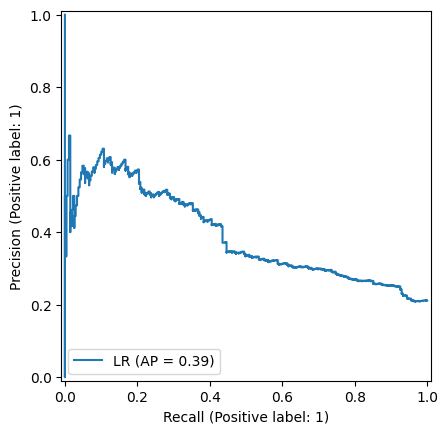

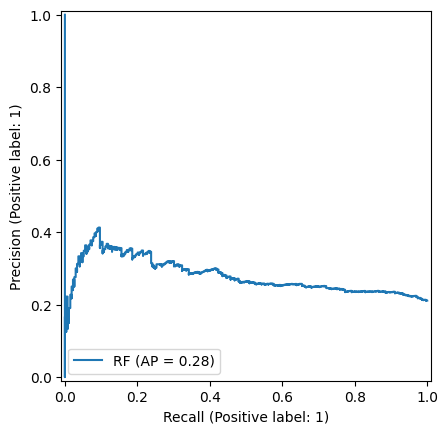

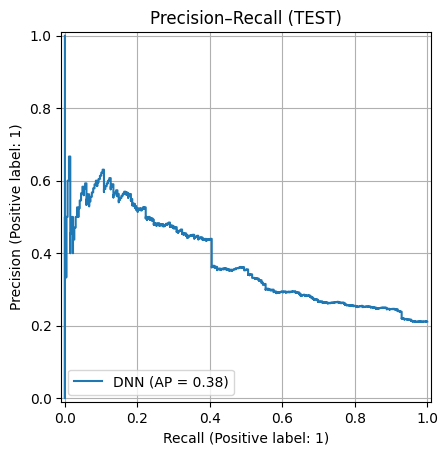

<Figure size 600x500 with 0 Axes>

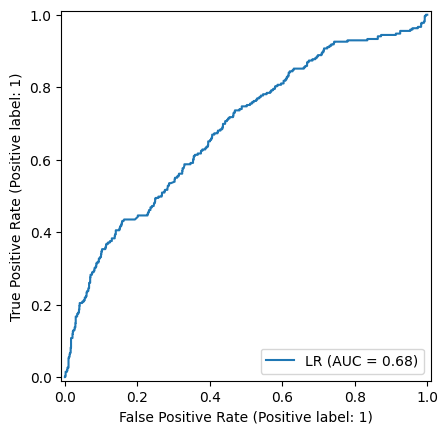

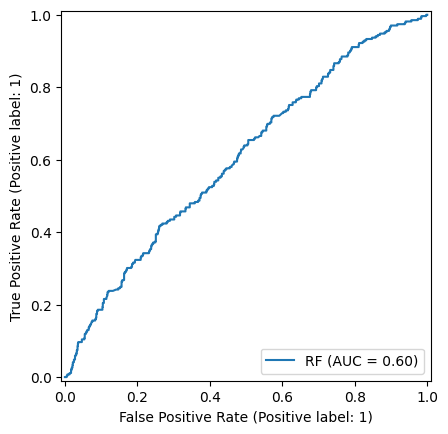

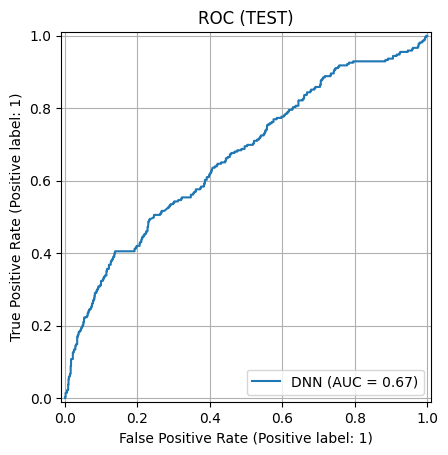

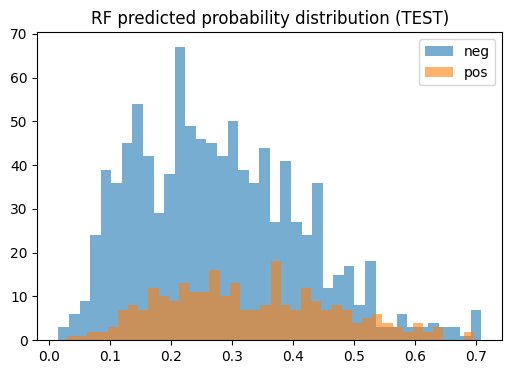

In [21]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# collect probs
models = {
    "LR": proba_lr,
    "RF": proba_rf,
    "DNN": proba_dnn
}
y_true = yte

# PR curves
plt.figure(figsize=(6,5))
for name, proba in models.items():
    PrecisionRecallDisplay.from_predictions(y_true, proba, name=name)
plt.title("Precision–Recall (TEST)")
plt.grid(True); plt.show()

# ROC curves
plt.figure(figsize=(6,5))
for name, proba in models.items():
    RocCurveDisplay.from_predictions(y_true, proba, name=name)
plt.title("ROC (TEST)")
plt.grid(True); plt.show()

# Probability histograms
plt.figure(figsize=(6,4))
plt.hist(proba_rf[y_true==0], bins=40, alpha=0.6, label="neg")
plt.hist(proba_rf[y_true==1], bins=40, alpha=0.6, label="pos")
plt.title("RF predicted probability distribution (TEST)")
plt.legend(); plt.show()


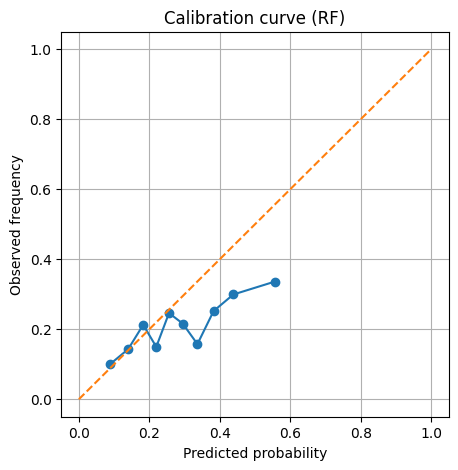

In [22]:
# Calibration curve (RF example)
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_true, proba_rf, n_bins=10, strategy="quantile")
plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1],'--')
plt.title("Calibration curve (RF)")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.grid(True); plt.show()


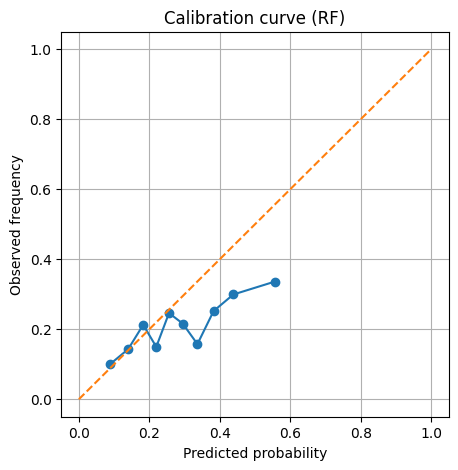

In [23]:
# Calibration curve (RF example)
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_true, proba_rf, n_bins=10, strategy="quantile")
plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1],'--')
plt.title("Calibration curve (RF)")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.grid(True); plt.show()


num__days_since_last_event 0.2201
num__cum_events 0.204
num__cum_leaks 0.155
num__event_year 0.1071
num__days_since_last_leak 0.0666
num__event_month 0.0663
num__m_cos 0.0563
num__m_sin 0.0545
num__prev_leak_flag 0.0307
num__final__PIPELINE AGE 0.0045
num__final__TOTAL LENGTH (KM) 0.0042
cat__final__SUB SYSTEM_Midmar 0.0041
cat__final__SYSTEM_Upper Mgeni 0.0041
cat__final__SYSTEM_Unknown 0.0039
cat__final__Material_Steel 0.0039
num__final__CAPACITY MLD 0.0038
cat__final__SUB SYSTEM_Unknown 0.0038
cat__final__Material_Unknown 0.0038
num__final__Nominal Diameter 0.0033


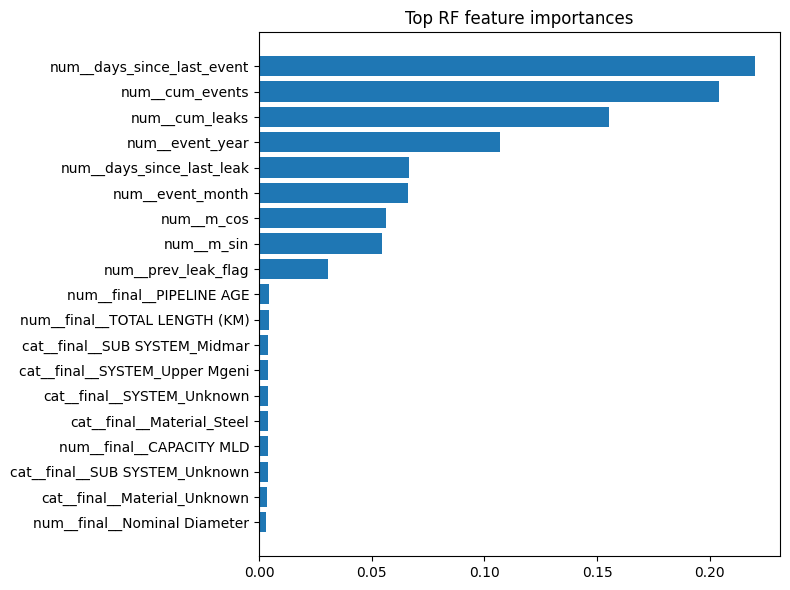

In [24]:
# Feature importance (RF) mapped to feature names
feat_names = preprocess.get_feature_names_out()
rf_model = pipe_rf.named_steps["clf"]
importances = rf_model.feature_importances_
top = sorted(zip(feat_names, importances), key=lambda x: x[1], reverse=True)[:20]
for n,v in top: print(n, round(float(v),4))

plt.figure(figsize=(8,6))
labels, vals = zip(*top[::-1])
plt.barh(range(len(vals)), vals)
plt.yticks(range(len(vals)), labels)
plt.title("Top RF feature importances"); plt.tight_layout(); plt.show()


#### **Ops view: Top-K list**

In [28]:
K = 100
risk = pd.DataFrame({
    "risk_prob": models["RF"],  # choose your production model
}, index=test.index)
out = test.join(risk).sort_values("risk_prob", ascending=False).head(K)
cols = [c for c in ["event_date","final__PIPELINE NAME","final__SYSTEM","final__SUB SYSTEM",TARGET,"risk_prob"] if c in out.columns]
out[cols].to_csv(f"outputs/top{K}_test.csv", index=False)
print(f"Saved Outputs/top{K}_test.csv")
print("Recall@K:", out[TARGET].sum(), "/", int(test[TARGET].sum()))
print("Precision@K:", round(out[TARGET].mean(),3))


Saved Outputs/top100_test.csv
Recall@K: 35 / 269
Precision@K: 0.35
